<a href="https://colab.research.google.com/github/andrehochuli/teaching/blob/main/teaching/AprendizadoMaquina%20/T%C3%B3pico%2004%20-%20Deep%20Learning/T%C3%B3pico_04_Deep_Learning_Redes_Neurais_Recorrentes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Redes Neurais Recorrentes

Neste notebook iremos abordar de forma técnica a implementação de uma Rede Neural Recorrente (RNN). A RNN é uma arquitetura de aprendizado profundo que se destaca na modelagem de sequências e dados temporais. Sua capacidade de capturar dependências de longo prazo a torna ideal para tarefas como processamento de linguagem natural, tradução automática, análise de sentimentos e previsão de séries temporais.

Também abordaremos as variantes da RNN, como a LSTM (Long Short-Term Memory) que foram desenvolvidas para superar o desafio do gradiente que desaparece ou explode.

Para a implementação utilizaremos a TensorFlow e uma base climática como exemplo.

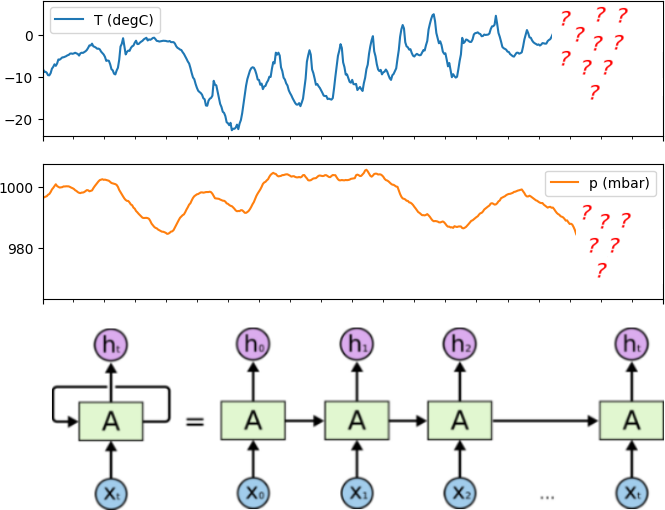


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

#Dataset - Dados Climáticos 
* [[link]](https://www.bgc-jena.mpg.de/wetter/)
* 14 caracteristicas (temp, pressão, umididade, etc). 

* Granularidade: 10 minutos desde 2003

* Utilizaremos a fração de 2009 até 2016. 

* Objetivo: Determinar uma temperatura no futuro utilizando diversos parâmetros.

In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [ ]:
df = pd.read_csv(csv_path)

In [ ]:
df.head(-20)

# Parte 1: Previsão univalorada


Primeiro vamos criar um modelo utilizando apenas uma *feature* (temperatura). Abaixo extraimos apenas a informação de temperatura do dataset.

In [ ]:
data = df['T (degC)']

data.index = df['Date Time']

print ("Numero de Amostras: ", len(data))
print ("Vetor de valores:" , data.values)
data.head()


Abaixo plotamos o gráfico de variação da temperatura desde 2009 a 2016

In [ ]:
data.plot(subplots=True)

In [ ]:
TRAIN_SPLIT = 300000 #300 mil observações para treino
tf.random.set_seed(13)

uni_data = data.values

#Criação dos Datasets de Treinamento e Validação

* A função abaixo retorna a fração do dataset a ser utilizada sendo:

          * history_size: janela a ser observada
          * target_size: O exato momento a ser avaliado 


In [ ]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    #if i < 1000: print(indices)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

Exemplo para a base de treinamento: univariate_data(dataset, 0, 300000, 50, 5), considerando janela histórica de tamanho 50 e rótulo 5 observações a frente.

start_index = 0

end_index = 300000

history_size = 50 (observações)

target_size = 5 (steps)

dataset = [t0, t1, ...., t300000]

treino = [[t0, .., t49],[t54], [t1, .., t50],[t55], [t2, .., t51],[t56] ...]

shape do treino = 299950 sequências de tamanho (50) + rótulo tamanho (1)


In [ ]:
'''Tamanho da Janela do Historico'''
univariate_past_history = 50  #50 observacoes anteriores
future = univariate_future_target = 5  # prever 5 observações a frente 

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)


In [ ]:
print(x_train_uni.shape)
print(x_train_uni[0],y_train_uni[0])

Para efeito de visualização, vamos analisar as janelas de observações criadas e sua respectiva temperatura (label)

In [ ]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'gX', 'ro']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
      future = delta
    else:
      future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
      if i:
        plt.plot(future, plot_data[i], marker[i], markersize=10,
                label=labels[i])
      else:
        plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

sample_id = 400
print("#Amostras:", len(x_train_uni),"#Labels: ", len(y_train_uni))
print ("Amostra[0]:\n", x_train_uni[sample_id],"\nTemperatura: ", y_train_uni[sample_id])
show_plot([x_train_uni[sample_id], y_train_uni[sample_id]], future, 'Sample Example')

#Modelo Baseline (Média)
Para efeitos comparativos, vamos criar um modelo de predição utilizando a média das últimas 20 observações. Este simples modelo nos revela como a média pode ser falha para prever séries temporais

In [ ]:
def baseline(history):
  return np.mean(history)

show_plot([x_train_uni[sample_id], y_train_uni[sample_id], baseline(x_train_uni[sample_id])], 0,
           'Baseline Prediction Example')

# Recurrent neural network (SimpleRNN and LSTM)

##Provedores de Dados da TF

In [ ]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

##Criando as arquiteturas

###RNN

In [ ]:
print(x_train_uni.shape[1])
print(x_train_uni.shape[2])
simple_rnn_model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(16, return_sequences=True, input_shape=(x_train_uni.shape[1], x_train_uni.shape[2])),    
    tf.keras.layers.SimpleRNN(8),
    tf.keras.layers.Dense(1)
])


simple_rnn_model.compile(optimizer='adam', loss='mae')

simple_rnn_model.summary()



###LSTM


In [ ]:

simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(16, return_sequences=True, input_shape=(x_train_uni.shape[1], x_train_uni.shape[2])),
    tf.keras.layers.LSTM(8),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')


simple_lstm_model.summary()

## Treinamento

Cada epoca conterá apenas 200 steps (lotes) ao invés da base toda. Podemos alterar este número depois para ver o impacto.

In [ ]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

###RNN

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
es=EarlyStopping(monitor='val_loss', verbose=1, patience=3)
rnn_log = simple_rnn_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50, callbacks=[es])

###LSTM

In [ ]:
lstm_log = simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

##Visualização do Treinamento

In [ ]:
simple_lstm_model.save('model')

jsmodel=simple_lstm_model.to_json()
with open('model_config.json', 'w') as json_file:
    json_file.write(jsmodel)

def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

In [ ]:
 plot_train_history(rnn_log,
                   'RNN Training and validation loss')
 plot_train_history(lstm_log,
                   'LSTM Training and validation loss')

In [ ]:
def plot_preds(plot_data, delta=0):
    labels = ['History', 'True Future', 'RNN Prediction','LSTM Prediction']
    marker = ['.-', 'gX', 'ro' , 'bo']
    time_steps = create_time_steps(plot_data[0].shape[0])
    

    future = delta

    plt.title('Predictions')
    for i, x in enumerate(plot_data):
      if i:
        plt.plot(future, plot_data[i], marker[i], markersize=10,
                label=labels[i])
      else:
        plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

for x, y in val_univariate.take(1):
  for sample in range(10):
    plot = plot_preds([x[sample].numpy(), y[sample].numpy(),
                    simple_rnn_model.predict(x)[sample], simple_lstm_model.predict(x)[sample]], future)
    plot.show()

print(simple_rnn_model.predict(x)[0])
print(val_univariate.take(1))

##Erro médio Quadrático

In [ ]:
#erro médio quadratico

y_true = []
y_pred_rnn = []
y_pred_lstm = []


for x_test, y_test in val_univariate.take(10):
  
  y_true.append(y_test)
  y_pred_rnn.append(simple_rnn_model.predict(x_test,verbose=0))
  y_pred_lstm.append(simple_lstm_model.predict(x_test,verbose=0))


   

y_true = np.array(y_true).flatten()
y_pred_rnn = np.array(y_pred_rnn).flatten()
y_pred_lstm = np.array(y_pred_lstm).flatten()

print(y_true.shape)


mse_rnn = np.sqrt(np.square(y_true - y_pred_rnn).mean())
mse_lstm = np.sqrt(np.square(y_true - y_pred_lstm).mean())

  
print(mse_rnn, mse_lstm)
  

#Exercícios

Para o melhor entendimento, algumas questões devem ser avaliadas!

* Se treinar por mais épocas e mais instâncias, aumenta a performance da rede? 

* A rede se comporta melhor para prever 1, 3, 5 ou 10 observações à frente?

* Se alterar o tamanho da janela de histórico, qual deve ser impacto? 

* Calcule uma taxa de acerto (use todas amostras de validação)

Existe alguma relação entre o tamanho da janela de histórico com o número de 'steps' que desejamos prever a frente?

Na sua opinião, a temperatura por si só, é eficiente como único dado para sua própria predição?
